# Web Scraping

In [2]:
from bs4 import BeautifulSoup
import requests,re, matplotlib.pyplot as plt
from itertools import count
import concurrent.futures
from tqdm import tqdm 

In [3]:
Warsaw = True
Krakow = False
page_count = 5

In [4]:
class Offer:
    iterator =(count(start = 1, step = 1))
    def __init__(self,title,link,price):
        self.id = next(self.iterator)
        self.title = title
        self.price = price
        self.link = 'https://www.gumtree.pl' + link
        if Warsaw:
            district_name_regex = 'wynajecia\/\w+'
            tmp = re.search(district_name_regex,self.link).group(0)
            district_name_regex2 = '\/\w+'
            # [1:]pozbywam sie '/' na poczatku 
            self.district = re.search(district_name_regex2,tmp).group(0)[1:]

        self.get_more_info()

    def __str__(self):
        return f'{self.id}. {self.title} {self.price}'
    #web scrap na trochę większą skalę 
    def get_more_info(self):
        response = requests.get(self.link)
        soup = BeautifulSoup(response.text, 'html.parser')
        other_info = [x.text for x in soup.find_all('div',{'class':'attribute'})]
        

        for i in range(len(other_info)):
            if 'Data dodania' in other_info[i]:
                # other_info[0] "Data dodania13/10/2021"
                date_regex = "\d{1,2}\/\d{1,2}\/\d{4}"
                self.date_added = re.search(date_regex,other_info[i]).group(0)

            if "Do wynajęcia przez" in other_info[i]:
                # other_info[2] 'Do wynajęcia przezWłaściciel'
                if 'Właściciel' in other_info[i]:
                    self.owner = 'Właściciel'
                else:
                    self.owner = 'Agencja'

            if "Dostępny" in other_info[i]:
                # other_info[3]'Dostępny od2021-11-03',
                date_regex2 = r"\d{4}\-\d{1,2}\-\d{1,2}"
                if re.search(date_regex2,other_info[i]) is not None:
                    self.access_date = re.search(date_regex2,other_info[i]).group(0)
                else:
                    self.access_date = 'brak'

            if "Rodzaj nieruchomości" in other_info[i]:
                # other_info[4] 'Rodzaj nieruchomościMieszkanie'
                if 'Mieszkanie' in other_info[i]:
                    self.property_type = 'Mieszkanie'
                elif 'Dom' in other_info[i]:
                    self.property_type = 'Dom'
                else :
                    self.property_type = 'Inne'


            # other_info[5] 'Liczba pokoi2 pokoje'
            if 'Liczba pokoi' in other_info[i]:
                room_regex = "\d+"

                if re.search(room_regex,other_info[i]) is not None:
                    self.room_count = re.search(room_regex,other_info[i]).group(0)
                elif "Kawalerka" in other_info[i]:
                    self.room_count = "Kawalerka"
                else:
                    self.room_count = 'brak'

            # other_info[6] 'Liczba łazienek1 łazienka',
            if 'Liczba łazienek' in other_info[i]:
                bathroom_regex="\d+"

                if re.search(bathroom_regex,other_info[i]) is not None:
                    self.bathroom_count = re.search(bathroom_regex,other_info[i]).group(0)
                else:
                    self.bathroom_count = 'brak'

            # other_info[7] 'Wielkość (m2)54'
            if "Wielkość" in other_info[i]:
                living_space_regex = "\d{2,3}"
                if re.search(living_space_regex,other_info[i]) is not None:
                    self.living_space = re.search(living_space_regex,other_info[i]).group(0)
                else:
                    self.living_space = 'brak'

            # other_info[8] 'PalącyNie'
            if "Palący" in other_info[i]:
                if len(other_info) == 9:
                    if 'Tak' in other_info[-1]:
                        self.smoker = 'Tak'
                    else:
                        self.smoker = 'Nie'
    

In [5]:
class Offers:
    def __init__(self,title):
        self.offers = {}
        self.title = title

    def add_offer(self,offer):
        assert type(offer) == Offer
        self.offers[offer.id] = offer

In [6]:
def extract_prices(regex,re_Match_objects_list):
    '''
            Temporary function. Need upgrade.
    
    input: regex -> dany wzorzec do wyszukiwaania 

        re_Match_objects_list -> lista stringów 

    output: lista zawierająca wszystkie wzorce wyszukane w stringu
    
    '''
    tmp =[]
    for single_element in re_Match_objects_list:
        # re.search -> Scan through string looking for a match to the pattern, returning a Match object, or None if no match was found.
        single_element =re.search(regex, str(single_element))
        try:
            # .group(0) returns the full string matched by the regex
            single_element = single_element.group(0)
        except (TypeError,AttributeError):
            single_element = '000'
        # funkcja zbudowana pod konkretny przpypadek - nie jest uniwersalna!
        single_element = "".join(single_element[0:-2].split())   
        tmp.append(int(single_element))
    return tmp

def displaymatch(match):
    if match is None:
        return None
    return ('%r') % (match.group(0))

In [7]:
prices_regex = "\d*\s{1}\d+\szł"
gumtree_offers = Offers("Oferty z gumtree")

In [8]:
no_threads = 10
# https://www.gumtree.pl/s-mieszkania-i-domy-do-wynajecia/krakow/page-2/v1c9008l3200208p2
def link_generator(page_count):
    if Krakow:
        links = [f"https://www.gumtree.pl/s-mieszkania-i-domy-do-wynajecia/krakow/page-{page_number}/v1c9008l3200208p{page_number}" for page_number in range(2,page_count+1)]
        
    if Warsaw:
        links = [f"https://www.gumtree.pl/s-mieszkania-i-domy-do-wynajecia/warszawa/page-{page_number}/v1c9008l3200008p{page_number}" for page_number in range(2,page_count+1)]

    return links

# with concurrent.futures.ThreadPoolExecutor(max_workers=no_threads) as executor:
#     for page in tqdm(link_generator(page_count)):
#         executor.submit(function_to_get_data_from_page, page)

for page_address in link_generator(page_count):
    if Krakow:
        html_text = requests.get(page_address)
    if Warsaw:
        html_text = requests.get(page_address)
    assert html_text.status_code == 200

    soup = BeautifulSoup(html_text.text, 'lxml')
    offers = soup.find_all('div',class_ = 'tileV1')

    links_2 = soup.find_all('a',class_='href-link tile-title-text', href=True)
    links_2 = [x['href'] for x in links_2]
    links =[offers[x].find('a',class_='href-link tile-title-text') for x in range(0,len(offers))] 

    titles = [x.text for x in links]

    prices = [offers[x].find('span',class_='ad-price') for x in range(0,len(offers))]
    prices = extract_prices(prices_regex,prices)


    assert len(offers)==len(prices)

    # print([displaymatch(match) for match in tmp])

    for i in range(len(offers)):
        gumtree_offers.add_offer(Offer(titles[i],links_2[i],prices[i]))

In [9]:
import pandas as pd
import numpy as np

In [10]:
d = {
# 'id': [x.id if hasattr(x, 'id') else np.nan for x in gumtree_offers.offers.values()],
'district': [x.district  if hasattr(x, 'district') else np.nan for x in gumtree_offers.offers.values()],
'living_space': [int(x.living_space) if hasattr(x, 'living_space') else np.nan for x in gumtree_offers.offers.values()],
'price': [x.price if hasattr(x, 'price') else np.nan for x in gumtree_offers.offers.values()],
'room_count': [x.room_count if hasattr(x, 'room_count') else np.nan for x in gumtree_offers.offers.values()],
'access_date': [x.access_date  if hasattr(x, 'access_date') else np.nan for x in gumtree_offers.offers.values()],
'bathroom_count': [int(x.bathroom_count) if hasattr(x, 'bathroom_count') else np.nan for x in gumtree_offers.offers.values()],
'date_added': [x.date_added if hasattr(x, 'date_added') else np.nan for x in gumtree_offers.offers.values()],
'owner': [x.owner if hasattr(x, 'owner') else np.nan for x in gumtree_offers.offers.values()],
'property_type': [x.property_type if hasattr(x, 'property_type') else np.nan for x in gumtree_offers.offers.values()],
'room_count': [x.room_count if hasattr(x, 'room_count') else np.nan for x in gumtree_offers.offers.values()],
'link': [x.link if hasattr(x, 'link') else np.nan for x in gumtree_offers.offers.values()],
'smoker': [x.smoker if hasattr(x, 'smoker') else np.nan for x in gumtree_offers.offers.values()],
'title': [x.title if hasattr(x, 'title') else np.nan for x in gumtree_offers.offers.values()]}
df = pd.DataFrame(data=d).sort_values(by=['district'])
df.head()


,district,living_space,price,room_count,access_date,bathroom_count,date_added,owner,property_type,link,smoker,title
88,bemowo,49.0,1800,2,NaN,NaN,18/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,"Umeblowane, ciche, w dobrej lokalizacji."
28,bemowo,200.0,8000,6,NaN,3.0,18/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Apartament 200m2 do wynajęcia
85,bemowo,49.0,1800,2,NaN,NaN,18/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,"Umeblowane, ciche, w dobrej lokalizacji."
38,bialoleka,34.0,1700,Kawalerka,NaN,1.0,18/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Okazja!!! Kawalerka w centrum Tarchomina
43,bialoleka,82.0,2700,3,NaN,1.0,18/11/2021,Agencja,Mieszkanie,https://www.gumtree.pl/a-mieszkania-i-domy-do-...,NaN,Duże 3 pokojowe mieszkanie w sercu Tarchomina


<BarContainer object of 12 artists>

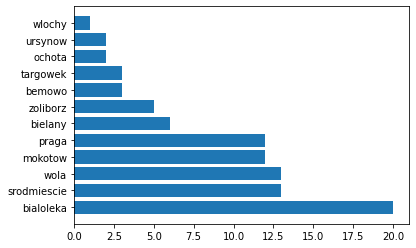

In [11]:
plt.barh(df["district"].value_counts().index, df["district"].value_counts().values)

In [12]:
pd.isna(df).sum()

district           0
living_space       2
price              0
room_count         2
access_date       69
bathroom_count    24
date_added         0
owner              4
property_type      1
link               0
smoker            91
title              0
dtype: int64

In [13]:
df.corr()

,living_space,price,bathroom_count
living_space,1.000000,0.829253,0.736419
price,0.829253,1.000000,0.610106
bathroom_count,0.736419,0.610106,1.000000


In [22]:
df["living_space"].fillna(df["living_space"].mean(), inplace=True)

In [15]:
# df.to_csv('gumtree_offers.csv',index=True, encoding='utf-8-sig')
# df = pd.read_csv('gumtree_offers.csv')

# Linear Regression with Scikit-Learn

(0.0, 8000.0)

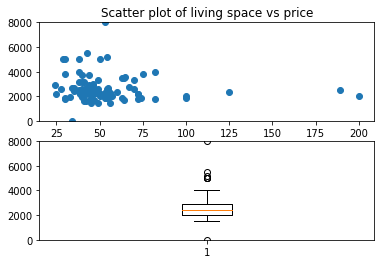

In [16]:
prices = [x.price for x in gumtree_offers.offers.values()]
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.scatter(df["living_space"],prices)
ax1.set_title('Scatter plot of living space vs price')

ax2.boxplot([price for price in prices if price <10000])
ax2.set_ylim(0,8000)


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
model.fit(df[["living_space"]],df["price"])
y_pred = model.predict(df[["living_space"]])
print("Coefficients: \n", model.coef_)

Coefficients: 
 [52.64699108]


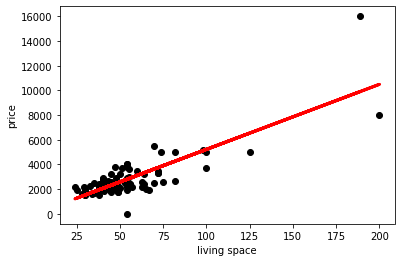

In [18]:
plt.scatter(df[["living_space"]],df["price"], color="black",)
plt.xlabel('living space')
plt.ylabel('price')
plt.plot(df[["living_space"]], y_pred, color="red", linewidth=3)

In [19]:
df["room_count"].replace(['brak',np.nan],0,inplace=True)
df["room_count"].replace('Kawalerka',1,inplace=True)
df["room_count"]=df["room_count"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 88 to 0
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        92 non-null     object 
 1   living_space    92 non-null     float64
 2   price           92 non-null     int64  
 3   room_count      92 non-null     int32  
 4   access_date     23 non-null     object 
 5   bathroom_count  68 non-null     float64
 6   date_added      92 non-null     object 
 7   owner           88 non-null     object 
 8   property_type   91 non-null     object 
 9   link            92 non-null     object 
 10  smoker          1 non-null      object 
 11  title           92 non-null     object 
dtypes: float64(2), int32(1), int64(1), object(8)
memory usage: 9.0+ KB


In [20]:
pd.isna(df).sum()
df["bathroom_count"] =  df["bathroom_count"].fillna(1)

In [21]:
regr_cols = ['living_space','bathroom_count','room_count']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[regr_cols], df["price"], test_size=0.2, random_state=0)
model2 = LinearRegression()
model2.fit(x_train,y_train)
y_pred2 = model2.predict(x_test)
model2.score(x_train, y_train)

0.7153390433047313